**Set Up**

In [1]:
# importing needed libraries
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import ConcatDataset, random_split, DataLoader
from torch.utils.data import DataLoader, TensorDataset
import torchvision
import torchvision.transforms as transforms

In [2]:


#define general class of MLP that uses relu, tanh or sigmoid activation and has prescribed widhts/depths

class mult_layer_percep(nn.Module):
    def __init__(self, input_len: int,layer_widths: np.ndarray|list, output_len: int, activation: str):
        super().__init__()

        assert input_len > 0 and output_len > 0
        assert all(h > 0 for h in layer_widths)

        if activation == "relu":
            act = nn.ReLU()
        elif activation == "tanh":
            act = nn.Tanh()
        elif activation == "sigmoid":
            act = nn.Sigmoid()
        else:
            raise ValueError("activation must be 'relu', 'tanh', or 'sigmoid'")

        layers = [] #list of layer and acivation modules in order
        sizes = [input_len] + list(layer_widths) + [output_len]


        for i in range(len(sizes) - 1):
            layers.append(nn.Linear(sizes[i],sizes[i+1])) #Build linear fully connected layers of desired size.
            if i < len(sizes)-2:
                layers.append(act)  #no activation on output outputs

                
        self.net = nn.Sequential(*layers)

    def forward(self,x):

        return self.net(x)

        
        


Loading CIFAR-10 data

In [3]:


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(torch.flatten)
])
   #transform data to torch tensor and flatten into vector form.

data_root = "./CIFAR10_data"

train_data = torchvision.datasets.CIFAR10(root=data_root, train=True,download=True,transform=transform) #load data
test_data = torchvision.datasets.CIFAR10(root=data_root,train=False, download=True,transform=transform) 

# splitting the data into 0.8-0.1-0.1 as required.
full_data = ConcatDataset([train_data, test_data])  

n_total = len(full_data)            
n_train = int(0.8 * n_total)        
n_val   = int(0.1 * n_total)        
n_test  = n_total - n_train - n_val 

g = torch.Generator().manual_seed(20)  # reproducible split
train_data, val_data, test_data = random_split(full_data, [n_train, n_val, n_test], generator=g)

batch_size = 200

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True,num_workers=2,pin_memory=True) #create data loaders for easy batching
test_loader  = DataLoader(test_data,  batch_size=batch_size, shuffle=False,num_workers=2,pin_memory=True)
val_loader = DataLoader(val_data,batch_size=batch_size,shuffle=True,num_workers=2,pin_memory=True)


100%|██████████| 170M/170M [00:03<00:00, 51.0MB/s] 


Creating Initial Model using a deep and wide fully connected neural net. 

In [4]:

#Initial model will have each hidden layer with width = 1024, 4 layers and use ReLu activaiton

deep_wide_model_config = {
    "input_len": 3*32*32,
    "layer_widths": [1024,1024,1024,1024],
    "output_len": 10,
    "activation": "relu",
}

deep_wide_model = mult_layer_percep(**deep_wide_model_config)





Training Set Up


In [5]:


loss_fn = nn.CrossEntropyLoss() #using cross entropy for classification task
optimizer = optim.Adam(deep_wide_model.parameters(), lr=1e-3) 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
deep_wide_model = deep_wide_model.to(device)




Training


In [6]:

def train_one_epoch(model, loader, loss_fn, optimizer, device):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for x, y in loader:
        x, y = x.to(device,non_blocking=True), y.to(device,non_blocking=True)

        optimizer.zero_grad()
        logits = model(x)
        loss = loss_fn(logits, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += x.size(0)

    return total_loss / total, correct / total

@torch.no_grad()
def evaluate(model, loader, loss_fn, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = loss_fn(logits, y)

        total_loss += loss.item() * x.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += x.size(0)

    return total_loss / total, correct / total




In [7]:
def train_for_n_epochs(n,model,train_loader,val_loader,loss_fn,optimizer,device):
    """ Trains model for n epochs with batches given in *_loader's, using optimizer and loss_fn"""

    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    best_loss = float("inf")
    for epoch in range(1, n+1):
        train_loss, train_acc = train_one_epoch(model, train_loader, loss_fn, optimizer, device)
        val_loss, val_acc = evaluate(model, val_loader, loss_fn, device)
        train_losses.append(train_loss);train_accs.append(train_acc);val_losses.append(val_loss);val_accs.append(val_acc)

        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(),"best_mlp_1.pt")


    return train_losses,train_accs,val_losses,val_accs,best_loss
        #print(f"Epoch {epoch}: train loss {train_loss:.4f}, acc {train_acc:.3f} | val loss {val_loss:.4f}, acc {val_acc:.3f}")

train_losses_1,train_accs_1,val_losses_1,val_accs_1,bets_loss_1 = train_for_n_epochs(25,deep_wide_model,train_loader,val_loader,loss_fn,optimizer,device)





In [8]:
torch.save(
    {
        "train_losses": train_losses_1,
        "train_accs": train_accs_1,
        "val_losses": val_losses_1,
        "val_accs": val_accs_1,
        "best_loss":bets_loss_1
    },
    "losses_model1.pt",
)


In [9]:


history = torch.load('/kaggle/working/losses_model1.pt')
history

{'train_losses': [1.9595395808418592,
  1.7541248455643654,
  1.659832171102365,
  1.5715081880489985,
  1.5158551022410394,
  1.4713414783279102,
  1.4289465089639029,
  1.3990784580508868,
  1.3621537193655968,
  1.3351154779394467,
  1.2933856417735419,
  1.2598377565542858,
  1.2204694683353106,
  1.183743820587794,
  1.1487737628320853,
  1.1064195218185584,
  1.069698815792799,
  1.024691924204429,
  0.9738230260709921,
  0.9247475596765677,
  0.8626443818211555,
  0.8159182677666347,
  0.7682900428771973,
  0.7044904438157876,
  0.6537131899346907],
 'train_accs': [0.2635625,
  0.359,
  0.40189583333333334,
  0.4355833333333333,
  0.4531875,
  0.4704375,
  0.48233333333333334,
  0.4953958333333333,
  0.5091666666666667,
  0.5184791666666667,
  0.5322708333333334,
  0.5448541666666666,
  0.5597291666666667,
  0.5711041666666666,
  0.5838125,
  0.5983958333333333,
  0.608375,
  0.6288333333333334,
  0.6435833333333333,
  0.6592916666666667,
  0.6815625,
  0.6992916666666666,
  0.7

Text(0, 0.5, 'Accuracy')

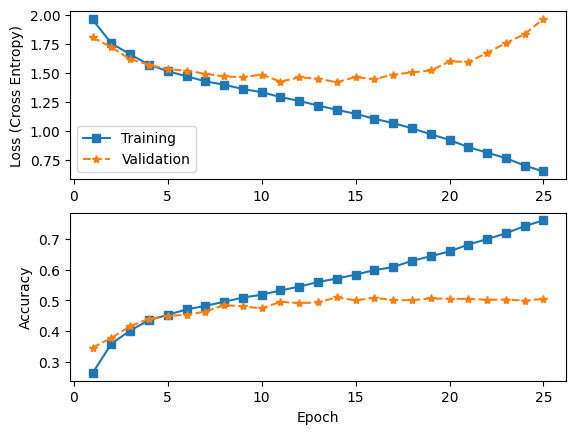

In [10]:

fig,axes = plt.subplots(2,1)

axes[0].plot(np.arange(1,26),train_losses_1,'s-',label="Training")
axes[0].plot(np.arange(1,26),val_losses_1,'*--',label="Validation")
#axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss (Cross Entropy)")
axes[0].legend()

axes[1].plot(np.arange(1,26),train_accs_1,'s-')
axes[1].plot(np.arange(1,26),val_accs_1,'*--')
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")

In [11]:
val_losses_1.index(bets_loss_1)



13